## Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto 2

### 1. Setting up the enviroment

In [1]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c anaconda beautifulsoup4 --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          90 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geopy-1.20.0         | 57 KB     | ##################################### | 100% 
geographiclib-1.49   | 

#### Import libraries

In [10]:
import numpy as np
import pandas as pd
import itertools
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
#!conda install -c anaconda beautifulsoup4 --yes

from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

# Visualization.
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import matplotlib.cm as mpcm
import matplotlib.colors as colors
import seaborn as sns

print('Libraries imported.')

Libraries imported.


### 2. Scraping Wikipedia for getting data 

#### Neighborhood Data

In [12]:
url_neigh = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urlopen(url_neigh).read().decode('utf-8')
soup = BeautifulSoup(page, 'html.parser')

wiki_table = soup.body.table.tbody

In [13]:
#### Demographics Data

In [14]:
url_demog = 'https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
page_demog = urlopen(url_demog).read().decode('utf-8')
soup_demog = BeautifulSoup(page_demog,'html.parser')

demographics_table = soup_demog.find_all('table')[1]
demographics_rows = demographics_table.find_all('tr')

demographics_data = []  # Demographics table is stored in here.

for row in demographics_rows:
    td = row.find_all('td')
    processed_row = [row.text.strip() for row in td if row.text.strip()]
    if processed_row:
        demographics_data.append(processed_row)

### 3. Building Data Frames from Tables scraped from the web

### Function for retrieving Borough data from table

In [15]:
def get_cell(element):
    cells = element.find_all('td')
    row = []
    
    for cell in cells:
        if cell.a:            
            if (cell.a.text):
                row.append(cell.a.text)
                continue
        row.append(cell.string.strip())
        
    return row

def get_row(table):    
    data = []  
    
    for tr in table.find_all('tr'):
        row = get_cell(tr)
        if len(row) != 3:
            continue
        data.append(row)        
    
    return data

In [16]:
borough_data = get_row(wiki_table)  # Borough table is stored here.

### Merge data from website

In [17]:
#Neighborhoods table

columns_borough = ['Postcode', 'Borough', 'Neighbourhood']
df_borough = pd.DataFrame(borough_data, columns=columns_borough)

df_borough = df_borough[df_borough.Borough != 'Not assigned']  # Getting rid of rows with 'Not assigned' Borough
df_borough.loc[df_borough['Neighbourhood'] == 'Not assigned', ['Neighbourhood']] = 'Queen\'s Park'  # Assigning the Borough to the 'Not assigned' Neighbourhood

df_borough.reset_index(inplace=True)
df_borough.drop('index', axis=1, inplace=True)

df_borough.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [18]:
#Demographics table

columns_demographics = ["Neighbourhood", "FM",  "Census", "Population", 
                        "Land Area", "Density",  "Population Change", 
                        "Average Income", "Transit Commuting", 
                        "Renters",  "2nd Language", "2nd Language %"]

df_demographics = pd.DataFrame(demographics_data, columns=columns_demographics)
df_demographics.drop(df_demographics.index[0], inplace=True)
df_demographics.reset_index(inplace=True)
df_demographics.drop(['index', 'FM', 'Census', 'Renters'], axis=1, inplace=True)
df_demographics['Borough'] = ''
df_demographics['Postcode'] = ''

df_demographics.head()

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode
0,Agincourt,"44,577",12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,,
1,Alderwood,"11,656",4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,,
2,Alexandra Park,"4,355",0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,
3,Allenby,"2,513",0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,
4,Amesbury,"17,318",3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,


### Tables merged

In [19]:
# This loop merges the borough and demographics data.
for i in df_demographics.index:
    for j in df_borough.index:
        if df_demographics.loc[i, 'Neighbourhood'] == df_borough.loc[j, 'Neighbourhood']:
            df_demographics.loc[i, 'Borough'] = df_borough.loc[j, 'Borough']
            df_demographics.loc[i, 'Postcode'] = df_borough.loc[j, 'Postcode']  
            
df1 = df_demographics.copy()
df1.head()

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode
0,Agincourt,"44,577",12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,Scarborough,M1S
1,Alderwood,"11,656",4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,Etobicoke,M8W
2,Alexandra Park,"4,355",0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,
3,Allenby,"2,513",0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,
4,Amesbury,"17,318",3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,


In [20]:
# Changing Population column to int64.
df1['Population'] = df1['Population'].str.replace(',','')
df1['Population'] = df1['Population'].apply(pd.to_numeric)

df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode
0,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,Scarborough,M1S
1,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,Etobicoke,M8W
2,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,
3,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,
4,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,
5,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian,,
6,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese,,
7,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian,North York,M3H
8,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin,,
9,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese,North York,M2K


In [21]:
#Geocoordenates
df_geo = pd.read_csv('Geospatial_Coordinates.csv')
df_geo= df_geo.rename(columns={'Postal Code':'Postcode'})
df_geo.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [22]:
df1['Latitude'] = ''
df1['Longitude'] = ''

# This loop merges the df1(borough and demographics) with geospatial data.
for i in df1.index:
    for j in df_geo.index:
        if df1.loc[i, 'Postcode'] == df_geo.loc[j, 'Postcode']:
            df1.loc[i, 'Latitude'] = df_geo.loc[j, 'Latitude']
            df1.loc[i, 'Longitude'] = df_geo.loc[j, 'Longitude']
            
df1.head()

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode,Latitude,Longitude
0,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,Scarborough,M1S,43.7942,-79.262
1,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,Etobicoke,M8W,43.6024,-79.5435
2,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,,,
3,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,,,
4,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,,,


### Add population score to the data frame

In [23]:
total_population = df1['Population'].sum()
df1['Population Score'] = df1['Population'] / total_population * 100  # Population score column added by computing the weight in the sum.
df_by_population = df1.sort_values('Population Score', ascending=False)
df_by_population.head(10)

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode,Latitude,Longitude,Population Score
112,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,,,,,2.161626
169,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,Scarborough,M1G,43.771,-79.2169,2.007928
49,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,,,,,1.987065
85,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,,,,,1.898439
0,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,Scarborough,M1S,43.7942,-79.262,1.845247
97,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,Scarborough,M1B,43.8067,-79.1944,1.834774
167,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,North York,M2M,43.7891,-79.4085,1.785929
43,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,North York,M6L,43.7138,-79.4901,1.515581
107,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,North York,M2M,43.7891,-79.4085,1.492110
138,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,,,,,1.448645


In [24]:
# Filling the remaining coordinates
geolocator = Nominatim(user_agent='my application')

address = ''

# Finding the missing coordinates with geolocator.
for i in df1.index:
    if df1.loc[i, 'Latitude'] == '':
        address = str(df1.iloc[i, 0]) + ', Toronto'
        location = geolocator.geocode(address)        
        if location:  # Found coordinates inserted to dataframe.
            latitude, longitude = location.latitude, location.longitude
            df1.loc[i, 'Latitude'] = latitude
            df1.loc[i, 'Longitude'] = longitude
        else:  # NaN inserted to dataframe for not found coordinates.
            df1.loc[i, 'Latitude'] = np.nan
            df1.loc[i, 'Longitude'] = np.nan
            
print('Coordinates inserted to df1.')

Coordinates inserted to df1.


In [25]:
df1.head()

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode,Latitude,Longitude,Population Score
0,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,Scarborough,M1S,43.7942,-79.262,1.845247
1,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,Etobicoke,M8W,43.6024,-79.5435,0.482495
2,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,,43.6508,-79.4043,0.180273
3,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,,43.7114,-79.5534,0.104025
4,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,,43.7062,-79.4835,0.716872


## 4. Visualizing Data

#### Visualize top neighbourhoods with highest population

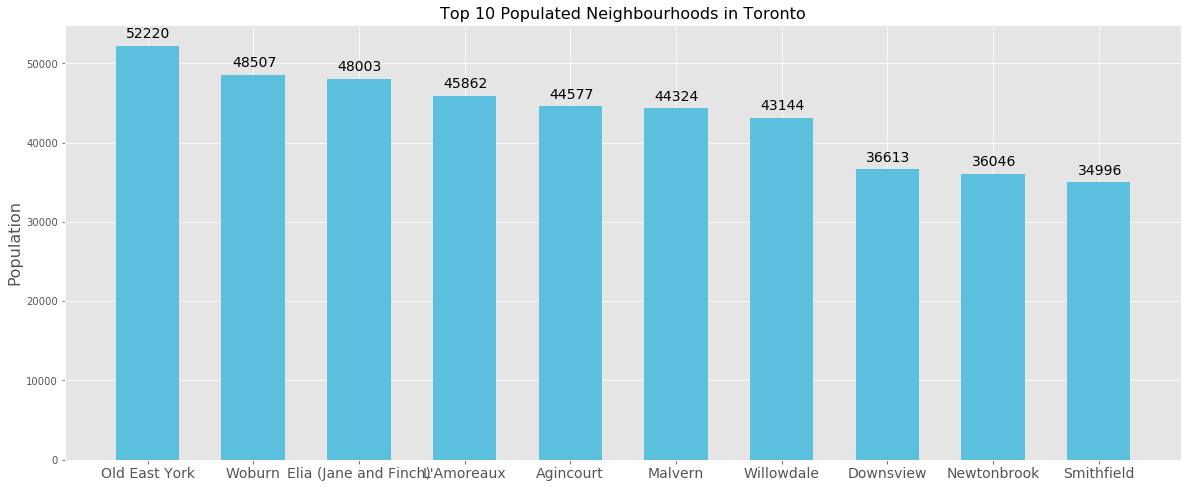

In [26]:
df_pop = df_by_population[['Neighbourhood', 'Population']].head(10).copy()
df_pop.set_index('Neighbourhood', inplace=True)

ind = np.arange(10)
populations = df_pop.Population.tolist()
bar_width = 0.6

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
plt.xticks(ind , (df_pop.index), rotation='horizontal', fontsize=14)
ax.bar(ind, populations, bar_width, color="#5bc0de")

ax.set_title('Top 10 Populated Neighbourhoods in Toronto', fontsize=16)
ax.set_ylabel("Population", fontsize=16)

for index, value in enumerate(populations):
    ax.text(index - bar_width / 3, value + 1000, "{}".format(value), fontsize=14)
     
ax

#### Visualization of neighbourhoods on Toronto map

In [31]:
df_neighbourhoods = df1[['Neighbourhood', 'Latitude', 'Longitude']]
df_neighbourhoods = df_neighbourhoods.dropna()
df_neighbourhoods.reset_index(inplace=True)
df_neighbourhoods.drop(['index'], axis=1, inplace=True)

toronto_location = geolocator.geocode('Toronto')
toronto_latitude, toronto_longitude = toronto_location.latitude, toronto_location.longitude
toronto_map = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

for latitude, longitude, neighbourhood in zip(df_neighbourhoods['Latitude'], df_neighbourhoods['Longitude'], df_neighbourhoods['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186ac',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  

toronto_map

### 5. Exploring data of Neighbourhoods

In [32]:
CLIENT_ID = 'ZOC4MSQQNRI3TSARVZ5LIQ1JIFWHWOEKRGXOFEFSO2SEUHKY' # your Foursquare ID
CLIENT_SECRET = 'CDQVPGMHUEIPSTYI1402JSI2JH1GBID2QGCMZXRYDUHAFXNP' # your Foursquare Secret
VERSION = '20190609'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZOC4MSQQNRI3TSARVZ5LIQ1JIFWHWOEKRGXOFEFSO2SEUHKY
CLIENT_SECRET:CDQVPGMHUEIPSTYI1402JSI2JH1GBID2QGCMZXRYDUHAFXNP


### Forming the API requests for all neighbourhoods in Toronto

In [33]:
#functions 
def get_neighbourhoods(df):
    neighbourhoods = {}
    for i in df.index:
        neighbourhoods[df.iloc[i, 0]] = (df.iloc[i, 1], df.iloc[i, 2])
    
    return neighbourhoods


def search_neighbourhood(neighbourhood, latitude, longitude):    
    LIMIT = 300
    radius = 5000
    search_query = 'Gym'  
      
    foursquare_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                                                  CLIENT_SECRET,
                                                                                                                                                  latitude,
                                                                                                                                                  longitude,
                                                                                                                                                  VERSION,
                                                                                                                                                  search_query,
                                                                                                                                                  radius,
                                                                                                                                                  LIMIT)
    return (neighbourhood, foursquare_url)

def form_urls():
    neighbourhoods_mapping = get_neighbourhoods(df_neighbourhoods)    
    search_urls = []
    
    for neighbourhood, coordinates in neighbourhoods_mapping.items():
        search_urls.append(search_neighbourhood(neighbourhood, coordinates[0], coordinates[1]))
        
    return search_urls

urls = form_urls()  # This list has all the API requests for every neighbourhood in Toronto.
print(len(urls), 'API requests formed.')

166 API requests formed.


In [34]:
#Collecting gym data with the API requests

def search_toronto(urls):
    
    df_toronto_gyms = pd.DataFrame()
    
    for neighbourhood, api_request in urls:
        results = requests.get(api_request).json()  # Sending each API request in the urls and collecting the data.
        results_json = results['response']['venues']
        df_top_venues = json_normalize(results_json)
        df_top_venues['Neighbourhood'] = neighbourhood  # Adding the neighbourhood to the corresponding column.
        df_toronto_gyms = df_toronto_gyms.append(df_top_venues, ignore_index=True, sort=True)
        
    return df_toronto_gyms

df_toronto_gyms = search_toronto(urls)

# Getting the category type of each row.
for i in df_toronto_gyms.index:
    if df_toronto_gyms.iloc[i, 1]:
        df_toronto_gyms.iloc[i, 1] = df_toronto_gyms.iloc[i, 1][0]['name']  

print(df_toronto_gyms.shape[0], 'Gyms found in Toronto.')

4927 Gyms found in Toronto.


In [35]:
df_toronto_gyms.head()

,Neighbourhood,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,Agincourt,Gym,False,4bf1cad7d39ad13a10aaaa0e,70 Town Centre Court,CA,Scarborough,Canada,NaN,2294,"[70 Town Centre Court, Scarborough ON M1P 0B2,...","[{'label': 'display', 'lat': 43.77419458033222...",43.774195,-79.255150,M1P 0B2,ON,EQ1 - Gym,v-1567020134,NaN
1,Agincourt,Gym / Fitness Center,False,5307aeba11d2dbce9bcb6a97,1455 Mccowan Rd,CA,Toronto,Canada,NaN,1198,"[1455 Mccowan Rd, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.78457971292356...",43.784580,-79.255324,NaN,ON,World Gym,v-1567020134,NaN
2,Agincourt,Gym / Fitness Center,False,4d4b9142fbeb2c0fe189203a,Agincourt Collegiate Institute,CA,Scarborough,Canada,NaN,1506,"[Agincourt Collegiate Institute, Scarborough O...","[{'label': 'display', 'lat': 43.78834, 'lng': ...",43.788340,-79.278932,NaN,ON,A.C.I Weight Training (GYM),v-1567020134,NaN
3,Agincourt,Gym,False,5be34dbdc824ae003711be6f,3 Clayton Dr,CA,Markham,Canada,NaN,5324,"[3 Clayton Dr, Markham ON L3R 8N3, Canada]","[{'label': 'display', 'lat': 43.828122, 'lng':...",43.828122,-79.308755,L3R 8N3,ON,Gym,v-1567020134,NaN
4,Agincourt,Residential Building (Apartment / Condo),False,5011ace6e4b06a7cd9ab3faa,NaN,CA,Toronto,Canada,NaN,2368,"[Toronto ON, Canada]","[{'label': 'display', 'lat': 43.77653588997592...",43.776536,-79.245597,NaN,ON,Gym Room,v-1567020134,NaN


#### Cleaning data

In [37]:
# Dropping rows where the category is not Gym.
for i in df_toronto_gyms.index:
    if df_toronto_gyms.iloc[i, 1] == []:
        df_toronto_gyms.iloc[i, 1] = ''
    if df_toronto_gyms.iloc[i, 1].find('Gym') == -1:
        df_toronto_gyms.iloc[i, 1] = np.nan
        
df_toronto_gyms.dropna(subset=['categories'], inplace=True)

In [38]:
# Dropping and renaming columns
df_gyms = df_toronto_gyms.drop(['location.cc', 
                    'location.country', 
                    'location.crossStreet', 
                    'location.labeledLatLngs',
                     'referralId',
                     'hasPerk',
                     'location.address',
                     'location.postalCode',
                     'location.state',
                     'location.city', 
                     'location.formattedAddress'], axis=1)

df_gyms = df_gyms.reindex(['name', 'Neighbourhood', 'categories', 'location.distance', 'location.lat', 'location.lng', 'id'], axis=1)
df_gyms.rename(columns={'name':'Name', 'categories':'Category', 'location.distance':'Distance', 'location.lat':'Latitude', 'location.lng':'Longitude', 'id':'VenueID'}, inplace=True)
df_gyms.reset_index(inplace=True)
df_gyms.drop(['index'], axis=1, inplace=True)

In [39]:
print('There are {} gyms in Toronto after cleaning the data.\n'.format(df_gyms.shape[0]))

df_gyms.drop_duplicates(subset=['VenueID'], keep=False, inplace=True)

print('There are {} gyms in Toronto after dropping the duplicates.\n'.format(df_gyms.shape[0]))

df_gyms.reset_index(inplace=True)
df_gyms.drop(['index'], axis=1, inplace=True)
df_gyms.head()

There are 3608 gyms in Toronto after cleaning the data.

There are 27 gyms in Toronto after dropping the duplicates.



,Name,Neighbourhood,Category,Distance,Latitude,Longitude,VenueID
0,Sheraton Gateway Gym,Allenby,Gym / Fitness Center,6040,43.686321,-79.620017,4f8cecf4e4b04bd7c548047f
1,Gym,Bayview Woods – Steeles,Gym,5975,43.842250,-79.425346,51caef5a498ed37e7db65cf1
2,Bayview Place Gym,Bayview Woods – Steeles,Gym,5087,43.841229,-79.404016,51f53565498e8378e402aaea
3,Gym @ Vista/Beverly Condo,Branson,Gym,4627,43.812821,-79.452578,4d5a90ab35966dcbaa786228
4,West Harbour City Gym,Brockton,Gym,2034,43.636440,-79.402944,4d690bf8b6f46dcb357d1cb2


In [40]:
# Grouping the gyms in neighbourhoods by their count and displaying the top neighbourhoods.
df_gym_counts = df_gyms.groupby('Neighbourhood').count().drop(['Name', 'Category', 'Distance', 'Latitude', 'Longitude'], axis=1).rename(columns={'VenueID':'GymCount'})
df_gym_counts = df_gym_counts.sort_values(by=['GymCount'], ascending=False)
df_gym_counts.head(10)

,GymCount
Neighbourhood,
Fashion District,6
Garden District,4
Financial District,3
Bayview Woods – Steeles,2
Port Lands,2
Allenby,1
Branson,1
Brockton,1
Christie Pits,1


In [41]:
# Adding the column of percentage in total.
gym_count = df_gym_counts['GymCount'].sum()
df_gym_counts['Weight'] = df_gym_counts['GymCount'] / gym_count * 100
df_gym_counts = df_gym_counts.reset_index()
df_gym_counts.head(10)

,Neighbourhood,GymCount,Weight
0,Fashion District,6,22.222222
1,Garden District,4,14.814815
2,Financial District,3,11.111111
3,Bayview Woods – Steeles,2,7.407407
4,Port Lands,2,7.407407
5,Allenby,1,3.703704
6,Branson,1,3.703704
7,Brockton,1,3.703704
8,Christie Pits,1,3.703704
9,Discovery District,1,3.703704


In [42]:
#Merging neighbourhood and gym data
df_ng = df1.drop(columns=['2nd Language', '2nd Language %', 'Transit Commuting', 'Density'], axis=1)
df_ng['GymCount'] = 0
df_ng['GymScore'] = 0

# Adding Gym Count and Weight to the previous data frame.
for i in df_ng.index:
    for j in df_gym_counts.index:        
        if df_ng.loc[i, 'Neighbourhood'] == df_gym_counts.loc[j, 'Neighbourhood']:
            df_ng.loc[i, 'GymCount'] = df_gym_counts.loc[j, 'GymCount']
            df_ng.loc[i, 'GymScore'] = df_gym_counts.loc[j, 'Weight']
            
df_ng.columns = df_ng.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df_ng.head(10)

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore
0,Agincourt,44577,12.45,4.6,"25,750",Scarborough,M1S,43.7942,-79.262,1.845247,0,0.000000
1,Alderwood,11656,4.94,-4.0,"35,239",Etobicoke,M8W,43.6024,-79.5435,0.482495,0,0.000000
2,Alexandra Park,4355,0.32,0.0,"19,687",,,43.6508,-79.4043,0.180273,0,0.000000
3,Allenby,2513,0.58,-1.0,"245,592",,,43.7114,-79.5534,0.104025,1,3.703704
4,Amesbury,17318,3.51,1.1,"27,546",,,43.7062,-79.4835,0.716872,0,0.000000
5,Armour Heights,4384,2.29,2.0,"116,651",,,43.7439,-79.4309,0.181474,0,0.000000
6,Banbury,6641,2.72,5.0,"92,319",,,43.7428,-79.37,0.274902,0,0.000000
7,Bathurst Manor,14945,4.69,12.3,"34,169",North York,M3H,43.7543,-79.4423,0.618642,0,0.000000
8,Bay Street Corridor,4787,0.11,3.0,"40,598",,,43.6643,-79.3871,0.198156,0,0.000000
9,Bayview Village,12280,4.14,41.6,"46,752",North York,M2K,43.7869,-79.386,0.508326,0,0.000000


In [43]:
# Changing the types for plotting
df_ng['average_income'] = df_ng['average_income'].str.replace(',','')
df_ng.loc[63, 'average_income'] = 45792
df_ng['average_income'] = df_ng['average_income'].apply(pd.to_numeric)
df_ng['land_area'] = df_ng['land_area'].apply(pd.to_numeric)
df_ng['population_change'] = df_ng['population_change'].apply(pd.to_numeric)

In [44]:
df_ng.head()

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore
0,Agincourt,44577,12.45,4.6,25750,Scarborough,M1S,43.7942,-79.262,1.845247,0,0.000000
1,Alderwood,11656,4.94,-4.0,35239,Etobicoke,M8W,43.6024,-79.5435,0.482495,0,0.000000
2,Alexandra Park,4355,0.32,0.0,19687,,,43.6508,-79.4043,0.180273,0,0.000000
3,Allenby,2513,0.58,-1.0,245592,,,43.7114,-79.5534,0.104025,1,3.703704
4,Amesbury,17318,3.51,1.1,27546,,,43.7062,-79.4835,0.716872,0,0.000000


### 7. Visualizing the found data

In [45]:
# Separating the neighbourhoods with gym for training
df_with_gym = df_ng[df_ng['gymcount'] > 0].sort_values(by='gymcount', ascending=False).reset_index().drop(columns=['index'])
df_with_gym.head()

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore
0,Fashion District,4642,0.98,123.0,63282,,,43.6455,-79.395,0.192154,6,22.222222
1,Garden District,8240,0.52,17.0,37614,Downtown Toronto,M5B,43.6572,-79.3789,0.341092,4,14.814815
2,Financial District,548,0.47,6.0,63952,,,43.6487,-79.3815,0.022684,3,11.111111
3,Bayview Woods – Steeles,13298,4.07,-1.5,41485,,,43.7981,-79.383,0.550465,2,7.407407
4,Port Lands,571,6.10,-9.0,36243,,,43.6431,-79.3506,0.023636,2,7.407407


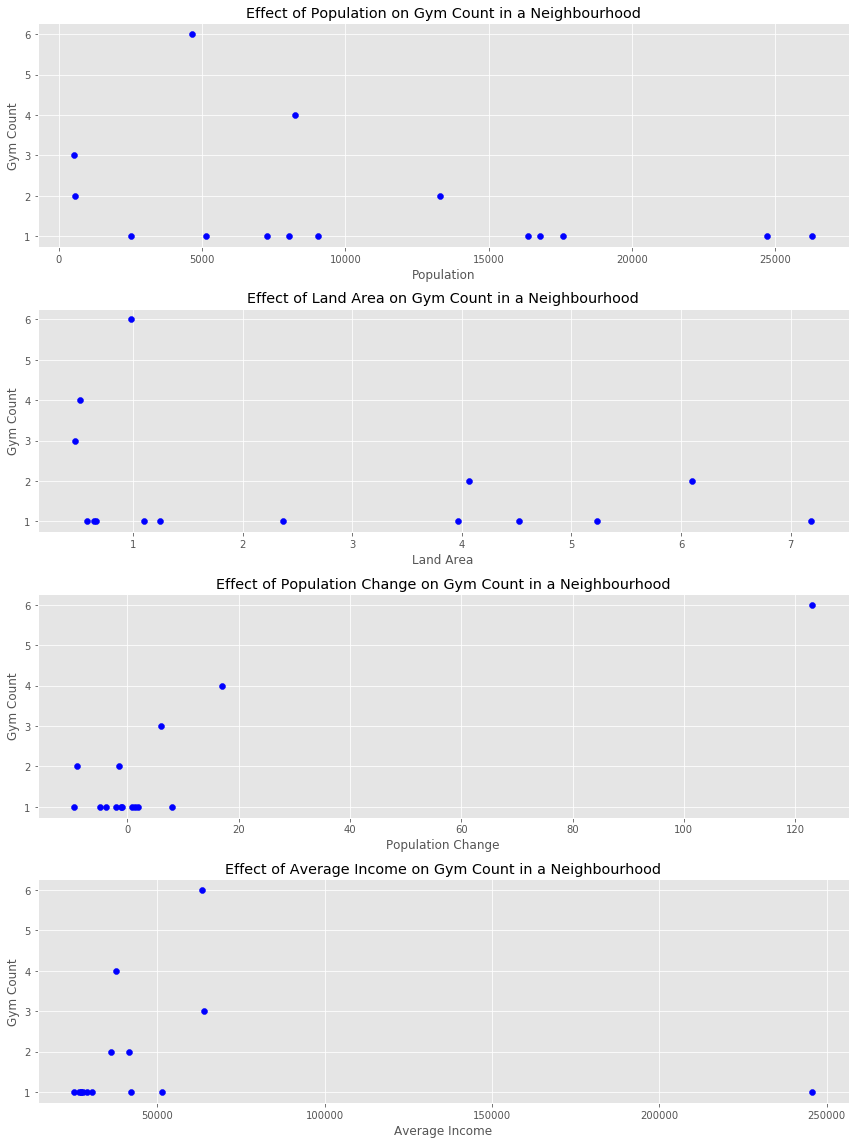

In [46]:
#Visualizing population, land_area, population_change and average_income as independent variables, and gym count as dependent variable
plt.figure(1, figsize=(12, 16))
plt.subplot(411)
x = np.asanyarray(df_with_gym[['population']])
y = np.asanyarray(df_with_gym[['gymcount']])
plt.scatter(x, y,  color='blue')
plt.title('Effect of Population on Gym Count in a Neighbourhood')
plt.xlabel("Population")
plt.ylabel("Gym Count")

plt.subplot(412)
x = np.asanyarray(df_with_gym[['land_area']])
y = np.asanyarray(df_with_gym[['gymcount']])
plt.scatter(x, y,  color='blue')
plt.title('Effect of Land Area on Gym Count in a Neighbourhood')
plt.xlabel("Land Area")
plt.ylabel("Gym Count")

plt.subplot(413)
x = np.asanyarray(df_with_gym[['population_change']])
y = np.asanyarray(df_with_gym[['gymcount']])
plt.scatter(x, y,  color='blue')
plt.title('Effect of Population Change on Gym Count in a Neighbourhood')
plt.xlabel("Population Change")
plt.ylabel("Gym Count")

plt.subplot(414)
x = np.asanyarray(df_with_gym[['average_income']])
y = np.asanyarray(df_with_gym[['gymcount']])
plt.scatter(x, y,  color='blue')
plt.title('Effect of Average Income on Gym Count in a Neighbourhood')
plt.xlabel("Average Income")
plt.ylabel("Gym Count")

plt.tight_layout()
plt.show()

In [47]:
df_corr = df_with_gym[['population', 'land_area', 'population_change', 'average_income', 'gymcount']].corr()
df_corr

,population,land_area,population_change,average_income,gymcount
population,1.000000,0.637577,-0.197208,-0.381050,-0.391859
land_area,0.637577,1.000000,-0.263936,-0.302986,-0.295886
population_change,-0.197208,-0.263936,1.000000,0.061153,0.848735
average_income,-0.381050,-0.302986,0.061153,1.000000,0.012928
gymcount,-0.391859,-0.295886,0.848735,0.012928,1.000000


There is no significant correlation between those variables and gym count in a neighbourhood.

### 8. Applying Machine Learning Algorithms
### Logistic Regression
#### Converting gym count to one hot encoding for logistic regression

In [48]:
# import Machine learning libraries.
from sklearn.cluster import KMeans 
from sklearn import linear_model
from sklearn.datasets.samples_generator import make_blobs
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [49]:
df_ng['gym'] = df_ng['gymcount'] > 0
df_ng.gym = df_ng.gym.astype(int)
df_ng.head()

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore,gym
0,Agincourt,44577,12.45,4.6,25750,Scarborough,M1S,43.7942,-79.262,1.845247,0,0.000000,0
1,Alderwood,11656,4.94,-4.0,35239,Etobicoke,M8W,43.6024,-79.5435,0.482495,0,0.000000,0
2,Alexandra Park,4355,0.32,0.0,19687,,,43.6508,-79.4043,0.180273,0,0.000000,0
3,Allenby,2513,0.58,-1.0,245592,,,43.7114,-79.5534,0.104025,1,3.703704,1
4,Amesbury,17318,3.51,1.1,27546,,,43.7062,-79.4835,0.716872,0,0.000000,0


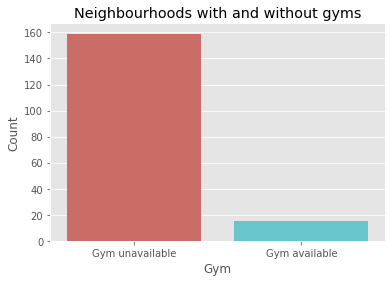

In [51]:
sns.countplot(x="gym", data=df_ng, palette="hls")
plt.title('Neighbourhoods with and without gyms')
plt.xlabel('Gym')
plt.ylabel('Count')
plt.xticks(np.arange(2), ('Gym unavailable', 'Gym available'))
plt.show()

In [52]:
#Scaling the dependent variables
# Preparing the data for training.
X = np.asarray(df_ng[['population', 'land_area', 'population_change', 'average_income', 'population_score']])
y = np.asarray(df_ng['gym'])

X = preprocessing.StandardScaler().fit(X).transform(X)
X[:5]

array([[ 2.98296051e+00,  2.52141131e+00, -7.53041737e-05,
        -5.63412778e-01,  2.98296051e+00],
       [-2.16507469e-01,  4.06250039e-01, -3.75692523e-01,
        -3.36723575e-01, -2.16507469e-01],
       [-9.26064157e-01, -8.94954365e-01, -2.00986840e-01,
        -7.08255928e-01, -9.26064157e-01],
       [-1.10508120e+00, -8.21726412e-01, -2.44663260e-01,
         4.68854296e+00, -1.10508120e+00],
       [ 3.33760983e-01,  3.49629486e-03, -1.52942777e-01,
        -5.20506907e-01,  3.33760983e-01]])

In [78]:
#Testing the model with split data¶
# Splitting the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15) 
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (121, 5) (121,)
Test set: (53, 5) (53,)


### Fitting the model.

In [79]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))
yhat[:5]

Accuracy of logistic regression classifier on test set: 0.92


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0, 0, 0, 0, 0])

In [80]:
# The probability of class 0 and 1.
yhat_prob = lr.predict_proba(X_test)
yhat_prob[:5]

array([[0.8968445 , 0.1031555 ],
       [0.85877909, 0.14122091],
       [0.89523236, 0.10476764],
       [0.89541706, 0.10458294],
       [0.92047293, 0.07952707]])

In [81]:
# Out of 10 neighbourhoods with gym only 2 of them predicted correctly.
# Out of 43 neighbourhoods without a gym only one of them can't be predicted correctly.
cm = confusion_matrix(y_test, yhat, labels=[1,0])
cm

array([[ 0,  3],
       [ 1, 49]])

In [82]:
cr = classification_report(y_test, yhat)
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        50
           1       0.00      0.00      0.00         3

   micro avg       0.92      0.92      0.92        53
   macro avg       0.47      0.49      0.48        53
weighted avg       0.89      0.92      0.91        53



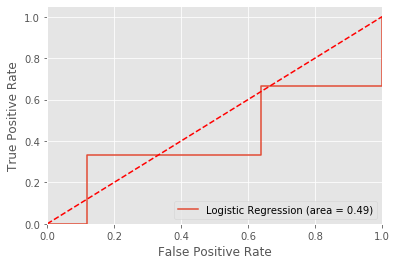

In [83]:
logit_roc_auc = roc_auc_score(y_test, yhat)
fpr, tpr, thresholds = roc_curve(y_test, yhat_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [84]:
#Fitting the model with the whole data
df_ng_pred = df_ng.copy()
predicted_values = lr.predict(X)
prediction_probabilities = lr.predict_proba(X)
df_ng_pred['Predicted Values'] = predicted_values
df_ng_pred['Prediction Probability'] = [p.max() for p in prediction_probabilities]

# This is the result of prediction.
df_lr = df_ng_pred[df_ng_pred['Predicted Values'] == 1].drop(columns=['population', 'land_area', 'population_change', 'average_income', 'borough', 'postcode', 'population_score'])
df_lr

,neighbourhood,latitude,longitude,gymcount,gymscore,gym,Predicted Values,Prediction Probability
130,Rouge,43.8067,-79.1944,0,0.0,0,1,0.524804


### Findings
According to the model, only the Rouge neighborhood is predicted as having a gym even though it doesn't have one. It is the only false negative in the confusion matrix. The model thinks it is the only neighborhood that has same characteristics with other neighborhoods with gyms.


In [85]:
df_lr[df_lr['gym'] == 0]

,neighbourhood,latitude,longitude,gymcount,gymscore,gym,Predicted Values,Prediction Probability
130,Rouge,43.8067,-79.1944,0,0.0,0,1,0.524804


### K-Means Clustering

In [87]:
# Preparing data for clustering
df_k = df_ng.drop(columns=['neighbourhood', 'borough', 'postcode'])
df_k['latitude'] = df_k['latitude'].apply(pd.to_numeric)
df_k['longitude'] = df_k['longitude'].apply(pd.to_numeric)
df_k.dropna(inplace=True)
df_k.reset_index(inplace=True)
df_k.drop(columns=['index'], inplace=True)

df_k.dtypes

population             int64
land_area            float64
population_change    float64
average_income         int64
latitude             float64
longitude            float64
population_score     float64
gymcount               int64
gymscore             float64
gym                    int64
dtype: object

In [88]:
df_k.head()

,population,land_area,population_change,average_income,latitude,longitude,population_score,gymcount,gymscore,gym
0,44577,12.45,4.6,25750,43.794200,-79.262029,1.845247,0,0.000000,0
1,11656,4.94,-4.0,35239,43.602414,-79.543484,0.482495,0,0.000000,0
2,4355,0.32,0.0,19687,43.650758,-79.404298,0.180273,0,0.000000,0
3,2513,0.58,-1.0,245592,43.711351,-79.553424,0.104025,1,3.703704,1
4,17318,3.51,1.1,27546,43.706162,-79.483492,0.716872,0,0.000000,0


In [89]:
#Initializing k and fitting the model
k = 15
k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12, random_state=150).fit(df_k) # random_state is fixed in order to minimize the entropy.
k_means.labels_

array([ 5,  0, 12,  9, 10,  1,  3,  0,  8,  7,  8,  3,  6,  7, 13,  8, 12,
        2, 12,  7, 11, 12,  3,  0,  3,  0,  0,  0,  0,  0, 13, 12, 11, 12,
        7,  3,  8,  7,  6, 10, 12,  5, 12, 10, 10, 10, 10,  5,  0,  6, 13,
       13, 10, 11,  8,  0, 10,  0, 12,  8,  8, 13, 12, 13,  7,  0, 10,  4,
        0,  8, 12,  3,  0, 12, 12,  7, 12, 12, 10,  0,  5,  8, 12,  0,  4,
        3,  3,  6,  0, 12,  0,  1,  5, 10,  7,  0,  6,  7, 14, 12, 10,  0,
        5,  8,  0, 12, 10,  5, 11,  6, 12,  6,  0, 10,  8,  7,  3, 12,  6,
        6,  7,  4,  6,  0,  8,  6, 10, 12,  8, 10,  5,  1, 12,  6,  3,  7,
       13,  6, 13, 13,  8, 12,  0, 11,  8, 10, 10,  8,  0,  7, 10, 12,  8,
        6,  8, 10,  0, 10, 10,  5,  0,  5, 13,  3,  6, 11], dtype=int32)

In [90]:
# Adding the cluster labels to the corresponding rows.
df_l = df_ng.copy()
df_l = df_l.dropna()
df_l['cluster'] = k_means.labels_
df_l.head()

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore,gym,cluster
0,Agincourt,44577,12.45,4.6,25750,Scarborough,M1S,43.7942,-79.262,1.845247,0,0.000000,0,5
1,Alderwood,11656,4.94,-4.0,35239,Etobicoke,M8W,43.6024,-79.5435,0.482495,0,0.000000,0,0
2,Alexandra Park,4355,0.32,0.0,19687,,,43.6508,-79.4043,0.180273,0,0.000000,0,12
3,Allenby,2513,0.58,-1.0,245592,,,43.7114,-79.5534,0.104025,1,3.703704,1,9
4,Amesbury,17318,3.51,1.1,27546,,,43.7062,-79.4835,0.716872,0,0.000000,0,10


In [91]:
#Cluster distribution
# Grouping neighbourhoods by their clusters.
df_counts = df_l.groupby('cluster').count()
df_counts = df_counts.drop(columns=[col for col in df_counts.columns if col != 'neighbourhood'], axis=1)
df_counts.sort_values(by='neighbourhood', ascending=False)

,neighbourhood
cluster,
0,27
12,25
10,22
8,18
6,15
7,13
3,11
5,10
13,10


In [92]:
#Cluster ranking
df_lg = df_l[df_l['gym'] > 0]
df_lg = df_lg.groupby('cluster').sum()
df_lg['score'] = df_lg['gymscore'] / df_counts['neighbourhood']  # Ranking clusters by gym per neighbourhood
df_lg.sort_values(by='score', ascending=False)

,population,land_area,population_change,average_income,population_score,gymcount,gymscore,gym,score
cluster,,,,,,,,,
9,2513,0.58,-1.0,245592,0.104025,1,3.703704,1,3.703704
13,5190,1.45,129.0,127234,0.214838,9,33.333333,2,3.333333
8,21131,10.83,-2.5,119726,0.874709,5,18.518519,3,1.028807
0,13364,1.16,12.0,68170,0.553197,5,18.518519,2,0.685871
6,50968,11.71,-0.1,51903,2.109800,2,7.407407,2,0.493827
10,33176,6.34,2.2,56781,1.373307,2,7.407407,2,0.336700
12,17056,2.35,-13.3,54416,0.706026,2,7.407407,2,0.296296
7,17602,5.23,-1.1,51398,0.728628,1,3.703704,1,0.284900


In [93]:
#Cluster with the highest score
df_best_cluster = df_l[df_l['cluster'] == 13].drop(columns=['borough', 'postcode'])
df_best_cluster

,neighbourhood,population,land_area,population_change,average_income,latitude,longitude,population_score,gymcount,gymscore,gym,cluster
14,Bloor West Village,5175,0.74,-2.0,55578,43.6493,-79.4844,0.214217,0,0.000000,0,13
31,Corktown,4484,0.67,77.0,54681,43.6574,-79.3565,0.185613,0,0.000000,0,13
52,Fashion District,4642,0.98,123.0,63282,43.6455,-79.395,0.192154,6,22.222222,1,13
53,Financial District,548,0.47,6.0,63952,43.6487,-79.3815,0.022684,3,11.111111,1,13
64,Harbourfront / CityPlace,14368,1.87,94.3,69232,43.6401,-79.3801,0.594758,0,0.000000,0,13
66,Henry Farm,2790,0.91,-6.0,56395,43.7785,-79.3466,0.115491,0,0.000000,0,13
144,Swansea,11133,3.76,0.5,58681,43.6516,-79.4844,0.460846,0,0.000000,0,13
146,The Annex,15602,1.47,-2.3,63636,43.6727,-79.4057,0.645839,0,0.000000,0,13
147,The Beaches,20416,3.57,7.8,67536,43.6764,-79.293,0.845112,0,0.000000,0,13
170,Wychwood,4182,0.68,-2.0,53613,43.6821,-79.4239,0.173112,0,0.000000,0,13


In [94]:
best_cluster = folium.Map(location=[latitude, longitude], zoom_start=11)

for latitude, longitude, neighbourhood in zip(df_best_cluster['latitude'], df_best_cluster['longitude'], df_best_cluster['neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(best_cluster)  

best_cluster

In [95]:
# Result
#According to the model, Bloor West Village should be in the cluster 13. 
#Cluster 13 is the cluster with the neighborhoods that has highest number of gyms. 
#All of the neighborhoods in this cluster has multiple gyms except Bloor West Village, but still it has the same characteristics as the other neighborhoods. Since they share the same characteristics, I think that, the demand for a gym in Bloor West Village will be high just like the other neighborhoods in the cluster.
#
df_best_cluster[df_best_cluster['gym'] == 0]

,neighbourhood,population,land_area,population_change,average_income,latitude,longitude,population_score,gymcount,gymscore,gym,cluster
14,Bloor West Village,5175,0.74,-2.0,55578,43.6493,-79.4844,0.214217,0,0.0,0,13
31,Corktown,4484,0.67,77.0,54681,43.6574,-79.3565,0.185613,0,0.0,0,13
64,Harbourfront / CityPlace,14368,1.87,94.3,69232,43.6401,-79.3801,0.594758,0,0.0,0,13
66,Henry Farm,2790,0.91,-6.0,56395,43.7785,-79.3466,0.115491,0,0.0,0,13
144,Swansea,11133,3.76,0.5,58681,43.6516,-79.4844,0.460846,0,0.0,0,13
146,The Annex,15602,1.47,-2.3,63636,43.6727,-79.4057,0.645839,0,0.0,0,13
147,The Beaches,20416,3.57,7.8,67536,43.6764,-79.293,0.845112,0,0.0,0,13
170,Wychwood,4182,0.68,-2.0,53613,43.6821,-79.4239,0.173112,0,0.0,0,13


In [97]:
#Final Result
df_ng[(df_ng.neighbourhood == 'Willowdale') | (df_ng.neighbourhood == 'Bloor West Village')]

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore,gym
14,Bloor West Village,5175,0.74,-2.0,55578,,,43.6493,-79.4844,0.214217,0,0.0,0
167,Willowdale,43144,7.68,62.3,39895,North York,M2M,43.7891,-79.4085,1.785929,0,0.0,0
